In [3903]:
import math
import matplotlib
import numpy as np
import pandas as pd
import pickle
import datetime
from plotly.offline import iplot
import yfinance as yf

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm_notebook

from matplotlib import pyplot as plt

%matplotlib inline

In [3904]:
need_row_data = False
load_data = True

seed = 42

period = '6y'
interval = '1d'

N = 10 

train_size = 0.9          # split data into train, validation, and test with ratio of 0.7, 0.15, 0.15
val_size = 0.9

# Load data

In [3905]:
if need_row_data:
    csvs = [
        '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'
    ]

    tickers = pd.DataFrame()
    for csv in csvs:
        data = pd.read_csv(f'data/row_jap/{csv}.csv')
        tickers = pd.concat([tickers, data], axis=0)

    with open('models/row_jap_stock.pickle', 'wb') as handle:
        pickle.dump(tickers, handle, protocol=pickle.HIGHEST_PROTOCOL)

    tickers = tickers[['ｺｰﾄﾞ', '会社名', '業種', '時価総額\r\n(10億円)']]
    tickers.rename(columns={"ｺｰﾄﾞ": "ticker", "会社名": "company", "業種":"sector", "時価総額\r\n(10億円)": "market_cap"}, inplace=True)
    tickers.replace(',','', regex=True, inplace=True)
    tickers['market_cap'] = tickers['market_cap'].astype(str).astype(int)

    with open('data/jap_ticker.pickle', 'wb') as handle:
        pickle.dump(tickers, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('data/jap_ticker.pickle', 'rb') as handle:
        tickers = pickle.load(handle)

tickers.head()

,ticker,company,sector,market_cap
0,7203,トヨタ自動車,自動車・自動車部品,33576
1,1306,ＮＥＸＴ ＦＵＮＤＳ ＴＯＰＩＸ連動型上,その他金融,15764
2,9432,日本電信電話,通信,13858
3,6758,ソニーグループ,電気機器,13658
4,6861,キーエンス,電気機器,11667


In [3906]:
if load_data:
    dfs = []

    forex_data = yf.download('USDJPY=X', period=period, interval=interval, progress=False)
    forex_data.rename({"Adj Close": 'forex'}, inplace=True, axis=1)
    forex = forex_data[['forex']]

    dji_data = yf.download('^dji', period=period, interval=interval, progress=False)
    dji_data.rename({"Adj Close": 'dji'}, inplace=True, axis=1)
    dji = dji_data[['dji']]#.shift(1)

    for i, company in tqdm_notebook(tickers.iterrows()):
        ticker = str(company["ticker"]) + '.T'
        try:
            temp_df = yf.download(ticker, period=period, interval=interval, progress=False)
            # create ticker column and sector column
            temp_df = pd.concat([temp_df, forex, dji], axis=1, join='inner')
            temp_df['ticker'] = ticker
            temp_df['sector'] = company["sector"]

            dfs.append(temp_df)
        except Exception as e: print(e)

else:
    with open('data/jp_company_data_2022_7_7.pickle', 'rb') as handle:
        dfs = pickle.load(handle)

dfs[0].tail()

0it [00:00, ?it/s]

,Open,High,Low,Close,Adj Close,Volume,forex,dji,ticker,sector
Date,,,,,,,,,,
2022-07-06,2089.0,2098.0,2043.5,2058.0,2058.0,32025100,135.520996,31037.679688,7203.T,自動車・自動車部品
2022-07-07,2086.5,2108.0,2065.0,2105.0,2105.0,27506300,135.966003,31384.550781,7203.T,自動車・自動車部品
2022-07-08,2120.5,2147.0,2108.0,2111.0,2111.0,35446600,135.912994,31338.150391,7203.T,自動車・自動車部品
2022-07-11,2140.0,2158.5,2134.0,2152.0,2152.0,28062000,136.300995,31173.839844,7203.T,自動車・自動車部品
2022-07-12,2152.0,2153.0,2110.5,2116.5,2116.5,24129000,137.388000,30981.330078,7203.T,自動車・自動車部品


In [3907]:
remove_df_i = []

for i, temp_df in enumerate(dfs):
    if temp_df.shape[0] == 0:
        print(temp_df.ticker)
        remove_df_i.append(i)
        continue
    temp_df.reset_index(inplace=True)
    # Change all column headings to be lower case, and remove spacing
    temp_df.columns = [str(x).lower().replace(' ', '_') for x in temp_df.columns]

    # Sort by datetime
    temp_df.sort_values(by='date', inplace=True, ascending=True)

    # Create returns column
    temp_df['daily_ret'] = 100.0 * ((temp_df['adj_close'].shift(-1) / temp_df['adj_close'])-1)

    # create weekday column
    date = pd.to_datetime(temp_df['date']).dt
    temp_df['weekday'] = date.weekday
    temp_df['month'] = date.month
    temp_df['year'] = date.year

for index in sorted(remove_df_i, reverse=True):
    del dfs[index]

dfs[0].tail()

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,sector,daily_ret,weekday,month,year
1426,2022-07-06,2089.0,2098.0,2043.5,2058.0,2058.0,32025100,135.520996,31037.679688,7203.T,自動車・自動車部品,2.283771,2,7,2022
1427,2022-07-07,2086.5,2108.0,2065.0,2105.0,2105.0,27506300,135.966003,31384.550781,7203.T,自動車・自動車部品,0.285036,3,7,2022
1428,2022-07-08,2120.5,2147.0,2108.0,2111.0,2111.0,35446600,135.912994,31338.150391,7203.T,自動車・自動車部品,1.942207,4,7,2022
1429,2022-07-11,2140.0,2158.5,2134.0,2152.0,2152.0,28062000,136.300995,31173.839844,7203.T,自動車・自動車部品,-1.649628,0,7,2022
1430,2022-07-12,2152.0,2153.0,2110.5,2116.5,2116.5,24129000,137.388000,30981.330078,7203.T,自動車・自動車部品,NaN,1,7,2022


# Feature Engineering

## Simple Moving Average

In [3908]:
# Simple moving average
for temp_df in dfs:
    temp_df['sma_10'] = temp_df['adj_close'].rolling(window = 10).mean()
    temp_df['sma_20'] = temp_df['adj_close'].rolling(window = 20).mean()
    temp_df['sma_50'] = temp_df['adj_close'].rolling(window = 50).mean()
    temp_df['sma_100'] = temp_df['adj_close'].rolling(window = 100).mean()
    temp_df['sma_200'] = temp_df['adj_close'].rolling(window = 200).mean()

    # Get the sma on the previous day
    temp_df['adj_close_lag_1'] = temp_df['adj_close'].shift(1)
    temp_df['sma_10_lag_1'] = temp_df['sma_10'].shift(1)
    temp_df['sma_20_lag_1'] = temp_df['sma_20'].shift(1)
    temp_df['sma_50_lag_1'] = temp_df['sma_50'].shift(1)
    temp_df['sma_100_lag_1'] = temp_df['sma_100'].shift(1)
    temp_df['sma_200_lag_1'] = temp_df['sma_200'].shift(1)

    # Get above signals
    temp_df['sma_above20'] = (temp_df['adj_close'] > temp_df['sma_20']).astype(int)
    temp_df['sma_above50'] = (temp_df['adj_close'] > temp_df['sma_50']).astype(int)
    temp_df['sma_above100'] = (temp_df['adj_close'] > temp_df['sma_100']).astype(int)
    temp_df['sma_above200'] = (temp_df['adj_close'] > temp_df['sma_200']).astype(int)

    temp_df['sma_10above20'] = (temp_df['sma_10'] > temp_df['sma_20']).astype(int)
    temp_df['sma_10above50'] = (temp_df['sma_10'] > temp_df['sma_50']).astype(int)
    temp_df['sma_10above100'] = (temp_df['sma_10'] > temp_df['sma_100']).astype(int)
    temp_df['sma_10above200'] = (temp_df['sma_10'] > temp_df['sma_200']).astype(int)

    # Get bullish crossover signals
    temp_df['sma_cut20'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_20_lag_1']) & (temp_df['sma_above20']==True)).astype(int)
    temp_df['sma_cut50'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_50_lag_1']) & (temp_df['sma_above50']==True)).astype(int)
    temp_df['sma_cut100'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_100_lag_1']) & (temp_df['sma_above100']==True)).astype(int)
    temp_df['sma_cut200'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_200_lag_1']) & (temp_df['sma_above200']==True)).astype(int)

    temp_df['sma_10cut20'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_20_lag_1']) & (temp_df['sma_10above20']==True)).astype(int)
    temp_df['sma_10cut50'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_50_lag_1']) & (temp_df['sma_10above50']==True)).astype(int)
    temp_df['sma_10cut100'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_100_lag_1']) & (temp_df['sma_10above100']==True)).astype(int)
    temp_df['sma_10cut200'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_200_lag_1']) & (temp_df['sma_10above200']==True)).astype(int)

    # Get bearish crossover signals
    temp_df['sma_cut20down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_20_lag_1']) & (temp_df['adj_close'] < temp_df['sma_20'])).astype(int)
    temp_df['sma_cut50down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_50_lag_1']) & (temp_df['adj_close'] < temp_df['sma_50'])).astype(int)
    temp_df['sma_cut100down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_100_lag_1']) & (temp_df['adj_close'] < temp_df['sma_100'])).astype(int)
    temp_df['sma_cut200down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_200_lag_1']) & (temp_df['adj_close'] < temp_df['sma_200'])).astype(int)

    temp_df['sma_10cut20down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_20_lag_1']) & (temp_df['sma_10'] < temp_df['sma_20'])).astype(int)
    temp_df['sma_10cut50down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_50_lag_1']) & (temp_df['sma_10'] < temp_df['sma_50'])).astype(int)
    temp_df['sma_10cut100down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_100_lag_1']) & (temp_df['sma_10'] < temp_df['sma_100'])).astype(int)
    temp_df['sma_10cut200down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_200_lag_1']) & (temp_df['sma_10'] < temp_df['sma_200'])).astype(int)

    dfs[0].head()

In [3909]:
# Del unneccesary cols
for df in dfs:
    df.drop(['sma_10', 'sma_50', 'sma_100', 'sma_200',
             'sma_10_lag_1', 'sma_20_lag_1', 'sma_50_lag_1', 'sma_100_lag_1', 'sma_200_lag_1'], axis=1, inplace=True)

## Exponential Moving Average

In [3910]:
for df in dfs:
    # Exponential moving average
    df['ema_10'] = df['adj_close'].ewm(span = 10, adjust=False).mean()
    df['ema_20'] = df['adj_close'].ewm(span = 20, adjust=False).mean()
    df['ema_50'] = df['adj_close'].ewm(span = 50, adjust=False).mean()
    df['ema_100'] = df['adj_close'].ewm(span = 100, adjust=False).mean()
    df['ema_200'] = df['adj_close'].ewm(span = 200, adjust=False).mean()

    # Get the ema on the previous day
    df['adj_close_lag_1'] = df['adj_close'].shift(1)
    df['ema_10_lag_1'] = df['ema_10'].shift(1)
    df['ema_20_lag_1'] = df['ema_20'].shift(1)
    df['ema_50_lag_1'] = df['ema_50'].shift(1)
    df['ema_100_lag_1'] = df['ema_100'].shift(1)
    df['ema_200_lag_1'] = df['ema_200'].shift(1)

    # Get above signals
    df['ema_above20'] = (df['adj_close'] > df['ema_20']).astype(int)
    df['ema_above50'] = (df['adj_close'] > df['ema_50']).astype(int)
    df['ema_above100'] = (df['adj_close'] > df['ema_100']).astype(int)
    df['ema_above200'] = (df['adj_close'] > df['ema_200']).astype(int)

    df['ema_10above20'] = (df['ema_10'] > df['ema_20']).astype(int)
    df['ema_10above50'] = (df['ema_10'] > df['ema_50']).astype(int)
    df['ema_10above100'] = (df['ema_10'] > df['ema_100']).astype(int)
    df['ema_10above200'] = (df['ema_10'] > df['ema_200']).astype(int)

    # Get bullish crossover signals
    df['ema_cut20'] = ((df['adj_close_lag_1'] < df['ema_20_lag_1']) & (df['ema_above20']==True)).astype(int)
    df['ema_cut50'] = ((df['adj_close_lag_1'] < df['ema_50_lag_1']) & (df['ema_above50']==True)).astype(int)
    df['ema_cut100'] = ((df['adj_close_lag_1'] < df['ema_100_lag_1']) & (df['ema_above100']==True)).astype(int)
    df['ema_cut200'] = ((df['adj_close_lag_1'] < df['ema_200_lag_1']) & (df['ema_above200']==True)).astype(int)

    df['ema_10cut20'] = ((df['ema_10_lag_1'] < df['ema_20_lag_1']) & (df['ema_10above20']==True)).astype(int)
    df['ema_10cut50'] = ((df['ema_10_lag_1'] < df['ema_50_lag_1']) & (df['ema_10above50']==True)).astype(int)
    df['ema_10cut100'] = ((df['ema_10_lag_1'] < df['ema_100_lag_1']) & (df['ema_10above100']==True)).astype(int)
    df['ema_10cut200'] = ((df['ema_10_lag_1'] < df['ema_200_lag_1']) & (df['ema_10above200']==True)).astype(int)

    # Get bearish crossover signals
    df['ema_cut20down'] = ((df['adj_close_lag_1'] > df['ema_20_lag_1']) & (df['adj_close'] < df['ema_20'])).astype(int)
    df['ema_cut50down'] = ((df['adj_close_lag_1'] > df['ema_50_lag_1']) & (df['adj_close'] < df['ema_50'])).astype(int)
    df['ema_cut100down'] = ((df['adj_close_lag_1'] > df['ema_100_lag_1']) & (df['adj_close'] < df['ema_100'])).astype(int)
    df['ema_cut200down'] = ((df['adj_close_lag_1'] > df['ema_200_lag_1']) & (df['adj_close'] < df['ema_200'])).astype(int)

    df['ema_10cut20down'] = ((df['ema_10_lag_1'] > df['ema_20_lag_1']) & (df['ema_10'] < df['ema_20'])).astype(int)
    df['ema_10cut50down'] = ((df['ema_10_lag_1'] > df['ema_50_lag_1']) & (df['ema_10'] < df['ema_50'])).astype(int)
    df['ema_10cut100down'] = ((df['ema_10_lag_1'] > df['ema_100_lag_1']) & (df['ema_10'] < df['ema_100'])).astype(int)
    df['ema_10cut200down'] = ((df['ema_10_lag_1'] > df['ema_200_lag_1']) & (df['ema_10'] < df['ema_200'])).astype(int)

dfs[0].head()

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,sector,daily_ret,weekday,month,year,sma_20,adj_close_lag_1,sma_above20,sma_above50,sma_above100,sma_above200,sma_10above20,sma_10above50,sma_10above100,sma_10above200,sma_cut20,sma_cut50,sma_cut100,sma_cut200,sma_10cut20,sma_10cut50,sma_10cut100,sma_10cut200,sma_cut20down,sma_cut50down,sma_cut100down,sma_cut200down,sma_10cut20down,sma_10cut50down,sma_10cut100down,sma_10cut200down,ema_10,ema_20,ema_50,ema_100,ema_200,ema_10_lag_1,ema_20_lag_1,ema_50_lag_1,ema_100_lag_1,ema_200_lag_1,ema_above20,ema_above50,ema_above100,ema_above200,ema_10above20,ema_10above50,ema_10above100,ema_10above200,ema_cut20,ema_cut50,ema_cut100,ema_cut200,ema_10cut20,ema_10cut50,ema_10cut100,ema_10cut200,ema_cut20down,ema_cut50down,ema_cut100down,ema_cut200down,ema_10cut20down,ema_10cut50down,ema_10cut100down,ema_10cut200down
0,2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896545,97297000,104.755997,18372.119141,7203.T,自動車・自動車部品,0.355360,2,7,2016,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,872.896545,872.896545,872.896545,872.896545,872.896545,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2016-07-14,1115.599976,1132.000000,1114.199951,1129.599976,875.998474,57826000,104.075996,18506.410156,7203.T,自動車・自動車部品,1.965308,3,7,2016,NaN,872.896545,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,873.460532,873.191967,873.018190,872.957970,872.927410,872.896545,872.896545,872.896545,872.896545,872.896545,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2016-07-15,1135.000000,1161.400024,1133.199951,1151.800049,893.214539,68174000,105.191002,18516.550781,7203.T,自動車・自動車部品,0.434100,4,7,2016,NaN,875.998474,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,877.052170,875.098879,873.810203,873.359090,873.129272,873.460532,873.191967,873.018190,872.957970,872.927410,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2016-07-19,1163.199951,1165.199951,1138.000000,1156.800049,897.091980,50186500,106.146004,18559.009766,7203.T,自動車・自動車部品,-0.155579,1,7,2016,NaN,893.214539,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,880.695772,877.193460,874.723214,873.829048,873.367707,877.052170,875.098879,873.810203,873.359090,873.129272,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2016-07-20,1148.000000,1156.800049,1145.800049,1155.000000,895.696289,38045500,106.137001,18595.029297,7203.T,自動車・自動車部品,1.731567,2,7,2016,NaN,897.091980,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,883.423139,878.955634,875.545688,874.262063,873.589882,880.695772,877.193460,874.723214,873.829048,873.367707,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3911]:
# Del unneccesary cols
for df in dfs:
    df.drop(['ema_10', 'ema_20', 'ema_50', 'ema_100', 'ema_200',
             'ema_10_lag_1', 'ema_20_lag_1', 'ema_50_lag_1', 'ema_100_lag_1', 'ema_200_lag_1'], axis=1, inplace=True)

## Moving Average Convergence Divergence

Implemented according to the definition in Investopedia:
https://www.investopedia.com/terms/m/macd.asp

In [3912]:
for df in dfs:
    # Exponential moving average
    df['ema_12'] = df['adj_close'].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df['adj_close'].ewm(span=26, adjust=False).mean()

    # MACD
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Get the macd on the previous day
    df['macd_lag_1'] = df['macd'].shift(1)
    df['macd_signal_lag_1'] = df['macd_signal'].shift(1)

    # Get bullish crossover signals
    df['macd_crossover'] = ((df['macd_lag_1'] < df['macd_signal_lag_1']) & \
                            (df['macd'] > df['macd_signal'])).astype(int)

    # Get bearish crossover signals
    df['macd_crossoverdown'] = ((df['macd_lag_1'] > df['macd_signal_lag_1']) & \
                            (df['macd'] < df['macd_signal'])).astype(int)

dfs[0].head()

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,sector,daily_ret,weekday,month,year,sma_20,adj_close_lag_1,sma_above20,sma_above50,sma_above100,sma_above200,sma_10above20,sma_10above50,sma_10above100,sma_10above200,sma_cut20,sma_cut50,sma_cut100,sma_cut200,sma_10cut20,sma_10cut50,sma_10cut100,sma_10cut200,sma_cut20down,sma_cut50down,sma_cut100down,sma_cut200down,sma_10cut20down,sma_10cut50down,sma_10cut100down,sma_10cut200down,ema_above20,ema_above50,ema_above100,ema_above200,ema_10above20,ema_10above50,ema_10above100,ema_10above200,ema_cut20,ema_cut50,ema_cut100,ema_cut200,ema_10cut20,ema_10cut50,ema_10cut100,ema_10cut200,ema_cut20down,ema_cut50down,ema_cut100down,ema_cut200down,ema_10cut20down,ema_10cut50down,ema_10cut100down,ema_10cut200down,ema_12,ema_26,macd,macd_signal,macd_lag_1,macd_signal_lag_1,macd_crossover,macd_crossoverdown
0,2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896545,97297000,104.755997,18372.119141,7203.T,自動車・自動車部品,0.355360,2,7,2016,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,872.896545,872.896545,0.000000,0.000000,NaN,NaN,0,0
1,2016-07-14,1115.599976,1132.000000,1114.199951,1129.599976,875.998474,57826000,104.075996,18506.410156,7203.T,自動車・自動車部品,1.965308,3,7,2016,NaN,872.896545,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,873.373765,873.126318,0.247447,0.049489,0.000000,0.000000,0,0
2,2016-07-15,1135.000000,1161.400024,1133.199951,1151.800049,893.214539,68174000,105.191002,18516.550781,7203.T,自動車・自動車部品,0.434100,4,7,2016,NaN,875.998474,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,876.426192,874.614334,1.811858,0.401963,0.247447,0.049489,0,0
3,2016-07-19,1163.199951,1165.199951,1138.000000,1156.800049,897.091980,50186500,106.146004,18559.009766,7203.T,自動車・自動車部品,-0.155579,1,7,2016,NaN,893.214539,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,879.605544,876.279345,3.326199,0.986810,1.811858,0.401963,0,0
4,2016-07-20,1148.000000,1156.800049,1145.800049,1155.000000,895.696289,38045500,106.137001,18595.029297,7203.T,自動車・自動車部品,1.731567,2,7,2016,NaN,897.091980,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,882.081043,877.717637,4.363406,1.662129,3.326199,0.986810,0,0


In [3913]:
for df in dfs:
    # Del unneccesary cols
    df.drop(['ema_12', 'ema_26', 'macd_signal', 'macd_lag_1', 'macd_signal_lag_1'], axis=1, inplace=True)

## Stochastic Oscillator
Implemented according to the definition in Investopedia:
https://www.investopedia.com/terms/s/stochasticoscillator.asp#:~:text=A%20stochastic%20oscillator%20is%20a,moving%20average%20of%20the%20result.

In [3914]:
for df in dfs:
    # Generate fast and slow stochastic oscillators
    df['lowest_14'] = df['close'].rolling(window = 14).min()
    df['highest_14'] = df['close'].rolling(window = 14).max()
    df['stochastic_fast'] = 100.0*(df['close'] - df['lowest_14'])/(df['highest_14'] - df['lowest_14'])
    df['stochastic_slow'] = df['stochastic_fast'].rolling(window = 3).mean()

    # Get the stochastics on the previous day
    df['stochastic_fast_lag_1'] = df['stochastic_fast'].shift(1)
    df['stochastic_slow_lag_1'] = df['stochastic_slow'].shift(1)

    # Get bullish crossover signals
    df['stochastic_fastcutslow'] = ((df['stochastic_fast_lag_1'] < df['stochastic_slow_lag_1']) & \
                                    (df['stochastic_fast'] > df['stochastic_slow'])).astype(int)

    # Get bearish crossover signals
    df['stochastic_fastcutslowdown'] = ((df['stochastic_fast_lag_1'] > df['stochastic_slow_lag_1']) & \
                                    (df['stochastic_fast'] < df['stochastic_slow'])).astype(int)

    # Get overbought/oversold signals
    df['stochastic_overs'] = (df['stochastic_fast'] < 20).astype(int)
    df['stochastic_overb'] = (df['stochastic_fast'] > 80).astype(int)

dfs[0].head()

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,sector,daily_ret,weekday,month,year,sma_20,adj_close_lag_1,sma_above20,sma_above50,sma_above100,sma_above200,sma_10above20,sma_10above50,sma_10above100,sma_10above200,sma_cut20,sma_cut50,sma_cut100,sma_cut200,sma_10cut20,sma_10cut50,sma_10cut100,sma_10cut200,sma_cut20down,sma_cut50down,sma_cut100down,sma_cut200down,sma_10cut20down,sma_10cut50down,sma_10cut100down,sma_10cut200down,ema_above20,ema_above50,ema_above100,ema_above200,ema_10above20,ema_10above50,ema_10above100,ema_10above200,ema_cut20,ema_cut50,ema_cut100,ema_cut200,ema_10cut20,ema_10cut50,ema_10cut100,ema_10cut200,ema_cut20down,ema_cut50down,ema_cut100down,ema_cut200down,ema_10cut20down,ema_10cut50down,ema_10cut100down,ema_10cut200down,macd,macd_crossover,macd_crossoverdown,lowest_14,highest_14,stochastic_fast,stochastic_slow,stochastic_fast_lag_1,stochastic_slow_lag_1,stochastic_fastcutslow,stochastic_fastcutslowdown,stochastic_overs,stochastic_overb
0,2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896545,97297000,104.755997,18372.119141,7203.T,自動車・自動車部品,0.355360,2,7,2016,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,2016-07-14,1115.599976,1132.000000,1114.199951,1129.599976,875.998474,57826000,104.075996,18506.410156,7203.T,自動車・自動車部品,1.965308,3,7,2016,NaN,872.896545,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.247447,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,2016-07-15,1135.000000,1161.400024,1133.199951,1151.800049,893.214539,68174000,105.191002,18516.550781,7203.T,自動車・自動車部品,0.434100,4,7,2016,NaN,875.998474,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.811858,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
3,2016-07-19,1163.199951,1165.199951,1138.000000,1156.800049,897.091980,50186500,106.146004,18559.009766,7203.T,自動車・自動車部品,-0.155579,1,7,2016,NaN,893.214539,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.326199,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
4,2016-07-20,1148.000000,1156.800049,1145.800049,1155.000000,895.696289,38045500,106.137001,18595.029297,7203.T,自動車・自動車部品,1.731567,2,7,2016,NaN,897.091980,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.363406,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0


In [3915]:
# Del unneccesary cols
for df in dfs:
    df.drop(['lowest_14', 
             'highest_14', 
             'stochastic_fast_lag_1', 
             'stochastic_slow_lag_1'], axis=1, inplace=True)

## Relative Strength Index
Implemented according to:

https://www.investopedia.com/terms/r/rsi.asp

https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi

In [3916]:
for df in tqdm_notebook(dfs):
    # Get gain and loss columns
    df['gain'] = df['daily_ret']
    df.loc[df['gain']<0, 'gain'] = 0

    df['loss'] = df['daily_ret']
    df.loc[df['loss']>0, 'loss'] = 0
    df['loss'] = abs(df['loss'])

    # Get avg_gain, avg_loss columns
    df['avg_gain'] = df['gain'].rolling(window = 14, min_periods=1).mean()
    df['avg_loss'] = df['loss'].rolling(window = 14, min_periods=1).mean()

    for index, row in df[15:].iterrows():
        df.loc[index, 'avg_gain'] = (df.loc[index-1, 'avg_gain']*13 + row['gain'])/14
        df.loc[index, 'avg_loss'] = (df.loc[index-1, 'avg_loss']*13 + row['loss'])/14

    # Calc RSI
    df['rsi'] = 100 - 100/(1+(df['avg_gain']/df['avg_loss']))
    df['rsi_ob'] = (df['rsi'] > 70).astype(int)
    df['rsi_os'] = (df['rsi'] < 30).astype(int)

dfs[0][20:25]

  0%|          | 0/300 [00:00<?, ?it/s]

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,sector,daily_ret,weekday,month,year,sma_20,adj_close_lag_1,sma_above20,sma_above50,sma_above100,sma_above200,sma_10above20,sma_10above50,sma_10above100,sma_10above200,sma_cut20,sma_cut50,sma_cut100,sma_cut200,sma_10cut20,sma_10cut50,sma_10cut100,sma_10cut200,sma_cut20down,sma_cut50down,sma_cut100down,sma_cut200down,sma_10cut20down,sma_10cut50down,sma_10cut100down,sma_10cut200down,ema_above20,ema_above50,ema_above100,ema_above200,ema_10above20,ema_10above50,ema_10above100,ema_10above200,ema_cut20,ema_cut50,ema_cut100,ema_cut200,ema_10cut20,ema_10cut50,ema_10cut100,ema_10cut200,ema_cut20down,ema_cut50down,ema_cut100down,ema_cut200down,ema_10cut20down,ema_10cut50down,ema_10cut100down,ema_10cut200down,macd,macd_crossover,macd_crossoverdown,stochastic_fast,stochastic_slow,stochastic_fastcutslow,stochastic_fastcutslowdown,stochastic_overs,stochastic_overb,gain,loss,avg_gain,avg_loss,rsi,rsi_ob,rsi_os
20,2016-08-12,1200.000000,1206.000000,1196.800049,1200.000000,930.593262,41309500,101.807999,18576.470703,7203.T,自動車・自動車部品,-0.833314,4,8,2016,903.342453,921.907898,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.181221,0,0,88.197419,84.978533,1,0,0,1,0.000000,0.833314,0.826161,0.567442,59.282390,0,0
21,2016-08-15,1200.000000,1201.400024,1190.000000,1190.000000,922.838501,27639500,101.282997,18636.050781,7203.T,自動車・自動車部品,-1.260527,0,8,2016,905.684454,930.593262,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.269206,0,0,77.467799,80.615172,0,1,0,0,0.000000,1.260527,0.767150,0.616948,55.425981,0,0
22,2016-08-16,1194.400024,1200.400024,1173.199951,1175.000000,911.205872,49875500,101.239998,18552.019531,7203.T,自動車・自動車部品,2.229798,1,8,2016,906.584021,922.838501,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.281757,0,0,61.373370,75.679529,0,0,0,0,2.229798,0.000000,0.871625,0.572880,60.340719,0,0
23,2016-08-17,1179.599976,1206.599976,1176.400024,1201.199951,931.523926,46661500,100.199997,18573.939453,7203.T,自動車・自動車部品,-1.764903,2,8,2016,908.305618,911.205872,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.011757,0,0,89.484921,76.108697,1,0,0,1,0.000000,1.764903,0.809366,0.658025,55.156808,0,0
24,2016-08-18,1187.000000,1196.400024,1180.000000,1180.000000,915.083435,50021000,99.905998,18597.699219,7203.T,自動車・自動車部品,2.135582,3,8,2016,909.274976,931.523926,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.146713,0,0,66.738180,72.532157,0,1,0,0,2.135582,0.000000,0.904095,0.611023,59.671605,0,0


In [3917]:
dfs[0]['gain'].shape

(1431,)

In [3918]:
# Del unneccesary cols
for df in dfs:
    df.drop(['gain', 
             'loss'
            ], axis=1, inplace=True)

## Average True Range
Implemented according to the definition in Investopedia: https://www.investopedia.com/terms/a/atr.asp

In [3919]:
for df in tqdm_notebook(dfs):
    # Get atr
    df['close_lag_1'] = df['close'].shift(1)
    df['tr'] = np.maximum(df['high']-df['low'], np.maximum(abs(df['high']-df['close_lag_1']), abs(df['low']-df['close_lag_1'])))
    df['atr'] = df['tr'].rolling(window = 14).mean()
    
    # Get bullish atr signal - buy when next day's price is above yesterday's closing + atr
    df['atr_signal'] = (df['high'] > ((df['close_lag_1'] + df['atr']))).astype(int)
    
    # Get bearish atr signal - sell when next day's price is below yesterday's closing - atr
    df['atr_signaldown'] = (df['low'] < ((df['close_lag_1'] - df['atr']))).astype(int)

  0%|          | 0/300 [00:00<?, ?it/s]

In [3920]:
# Del unneccesary cols
for df in dfs:
    df.drop(['close_lag_1'], axis=1, inplace=True)  

## Average Directional Index
Implemented according to:

https://www.investopedia.com/terms/a/adx.asp

https://school.stockcharts.com/doku.php?id=technical_indicators:average_directional_index_adx

In [3921]:
def comp_pdm(high, high_lag_1, low, low_lag_1):
    if (high-high_lag_1) > (low_lag_1-low):
        return(max(high-high_lag_1, 0))
    else:
        return 0

def comp_mdm(high, high_lag_1, low, low_lag_1):
    if (low_lag_1-low) > (high-high_lag_1):
        return(max(low_lag_1-low, 0))
    else:
        return 0

for i, df in tqdm_notebook(enumerate(dfs)):

    # Get +/- directional movement
    df['high_lag_1'] = df['high'].shift(1)
    df['low_lag_1'] = df['low'].shift(1)

    df['+dm'] = df.apply(lambda row: comp_pdm(row['high'], row['high_lag_1'], row['low'], row['low_lag_1']), axis=1)
    df['-dm'] = df.apply(lambda row: comp_mdm(row['high'], row['high_lag_1'], row['low'], row['low_lag_1']), axis=1)

    # Get smoothed +/- directional movement
    df['smoothed+dm'] = 0
    df.loc[14, 'smoothed+dm'] = df[1:15]['+dm'].sum()
    
    df['smoothed-dm'] = 0
    df.loc[14, 'smoothed-dm'] = df[1:15]['-dm'].sum()
    
    df['14tr'] = 0
    df.loc[14, '14tr'] = df[1:15]['tr'].sum()

    for index, row in df[15:].iterrows():
        df.loc[index, 'smoothed+dm'] = df.loc[index-1, 'smoothed+dm'] - (df.loc[index-1, 'smoothed+dm']/14) + row['+dm']
        df.loc[index, 'smoothed-dm'] = df.loc[index-1, 'smoothed-dm'] - (df.loc[index-1, 'smoothed-dm']/14) + row['-dm']
        df.loc[index, '14tr'] = df.loc[index-1, '14tr'] - (df.loc[index-1, '14tr']/14) + row['tr']
        
    # Get +/- directional index
    df['+di'] = 100.0*(df['smoothed+dm']/df['14tr'])
    df['-di'] = 100.0*(df['smoothed-dm']/df['14tr'])
    
    # Get directional movement index
    df['dx'] = 100.0 * (abs(df['+di']-df['-di'])/abs(df['+di']+df['-di']))
    
    # Get average directional movement index
    df.loc[27, 'adx'] = df[14:28]['dx'].mean()
    for index, row in df[28:].iterrows():
        df.loc[index, 'adx'] = (df.loc[index-1, 'adx']*13 + row['dx'])/14

    # Get adx strength and trendless
    df['adx_strength'] = (df['adx'] > 25).astype(int)
    df['adx_trendless'] = (df['adx'] < 20).astype(int)
    
    # Get adx signals
    df['+di_lag_1'] = df['+di'].shift(1)
    df['-di_lag_1'] = df['-di'].shift(1)
    df['adx_bull'] = ((df['+di_lag_1'] < df['-di_lag_1']) & (df['+di'] > df['-di']) & (df['adx_strength']==True)).astype(int)
    df['adx_bear'] = ((df['-di_lag_1'] < df['+di_lag_1']) & (df['-di'] > df['+di']) & (df['adx_strength']==True)).astype(int)


0it [00:00, ?it/s]

In [3922]:
# Del unneccesary cols
for df in dfs:
    df.drop(['+di',
             '-di',
             '+di_lag_1',
             '-di_lag_1',
             'tr', 
             '+dm', 
             '-dm', 
             'smoothed+dm',
             'smoothed-dm',
             '14tr',
             'dx',
             'tr'], axis=1, inplace=True)

## Bollinger Bands

In [3923]:
for df in dfs:
    df['std_20'] = df['adj_close'].rolling(window = 20).std()
    df['bollinger_upp'] = df['sma_20'] + 2*df['std_20']
    df['bollinger_low'] = df['sma_20'] - 2*df['std_20']
    
    # Get dist between bollinger bands and the price
    df['bollinger_upp_dist'] = df['bollinger_upp'] - df['adj_close']
    df['bollinger_low_dist'] = df['adj_close'] - df['bollinger_low']
    
    # Get signals
    df['bollinger_ob'] = (df['adj_close'] > df['bollinger_upp']).astype(int)
    df['bollinger_os'] = (df['adj_close'] < df['bollinger_low']).astype(int)


In [3924]:
# Del unneccesary cols
for df in dfs:
    df.drop(['std_20', 'bollinger_upp', 'bollinger_low'], axis=1, inplace=True)

In [3925]:
# Check if all signals true on any day
df = dfs[0]
df[(df['macd_crossover']==1) & 
   (df['stochastic_fastcutslow']==1) &
   (df['atr_signal']==1) & 
   (df['adx_bull']==1)]

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,sector,daily_ret,weekday,month,year,sma_20,adj_close_lag_1,sma_above20,sma_above50,sma_above100,sma_above200,sma_10above20,sma_10above50,sma_10above100,sma_10above200,sma_cut20,sma_cut50,sma_cut100,sma_cut200,sma_10cut20,sma_10cut50,sma_10cut100,sma_10cut200,sma_cut20down,sma_cut50down,sma_cut100down,sma_cut200down,sma_10cut20down,sma_10cut50down,sma_10cut100down,sma_10cut200down,ema_above20,ema_above50,ema_above100,ema_above200,ema_10above20,ema_10above50,ema_10above100,ema_10above200,ema_cut20,ema_cut50,ema_cut100,ema_cut200,ema_10cut20,ema_10cut50,ema_10cut100,ema_10cut200,ema_cut20down,ema_cut50down,ema_cut100down,ema_cut200down,ema_10cut20down,ema_10cut50down,ema_10cut100down,ema_10cut200down,macd,macd_crossover,macd_crossoverdown,stochastic_fast,stochastic_slow,stochastic_fastcutslow,stochastic_fastcutslowdown,stochastic_overs,stochastic_overb,avg_gain,avg_loss,rsi,rsi_ob,rsi_os,atr,atr_signal,atr_signaldown,high_lag_1,low_lag_1,adx,adx_strength,adx_trendless,adx_bull,adx_bear,bollinger_upp_dist,bollinger_low_dist,bollinger_ob,bollinger_os


In [3926]:
# Remove unnecessary cols
for df in dfs:
    df.drop(['open',
             'high', 
             'low',
             'close',
             'volume',
             'sma_20',
             'adj_close_lag_1',
             'high_lag_1',
             'low_lag_1',
             ], axis=1, inplace=True)

In [3927]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1431 entries, 0 to 1430
Data columns (total 84 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        1431 non-null   datetime64[ns]
 1   adj_close                   1431 non-null   float64       
 2   forex                       1431 non-null   float64       
 3   dji                         1431 non-null   float64       
 4   ticker                      1431 non-null   object        
 5   sector                      1431 non-null   object        
 6   daily_ret                   1430 non-null   float64       
 7   weekday                     1431 non-null   int64         
 8   month                       1431 non-null   int64         
 9   year                        1431 non-null   int64         
 10  sma_above20                 1431 non-null   int64         
 11  sma_above50                 1431 non-null   int64       

# EDA

In [3928]:
def add_lags(df_list, columns, N):
    dfs = [df.copy(deep=True) for df in df_list]
    for df in tqdm_notebook(dfs):
        for col in columns:
            for i in range(1, N):
                df[f'{col}_lag_{i}'] = df[col].shift(i)
    return dfs

In [3929]:
# create lag for daily return to N days ahead
dfs_lags = add_lags(dfs, ['daily_ret'], N)
dfs_lags = add_lags(dfs, ['dji'], 5)
dfs_lags[0].shape

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

(1431, 88)

In [3930]:
# Create lags for technical indicators
tech_indicators = list(set(dfs[0].columns) - set(['date', 'daily_ret', 'sector', 'ticker', 'weekday', 'month', 'year', 'dji']))
tech_indicators.sort()

dfs_lags = add_lags(dfs_lags, tech_indicators, 2)
dfs_lags[0].shape

  0%|          | 0/300 [00:00<?, ?it/s]

(1431, 164)

In [3931]:
#for df in dfs_lags:
#    df.drop([f'{tech_indicator}_lag_1' for tech_indicator in tech_indicators], axis=1, inplace=True)

In [3932]:
# Remove columns
for df in dfs_lags:
    df.drop(tech_indicators, axis=1, inplace=True)
dfs_lags[0].shape

(1431, 88)

# Encode Label

In [3933]:
df_lags = pd.concat(dfs_lags)

In [3934]:
df_lags.shape

(426934, 88)

In [3935]:
df_lags = df_lags[(abs(df_lags['daily_ret']) <= 50) | (df_lags['daily_ret'].isna())]

In [3936]:
with open('encoders/jp_date.pickle', 'rb') as handle:
    date_encoder = pickle.load(handle)

with open('encoders/jp_sector.pickle', 'rb') as handle:
    sector_encoder = pickle.load(handle)

with open('encoders/jp_ticker.pickle', 'rb') as handle:
    ticker_encoder = pickle.load(handle)

In [3937]:

a = np.array([pd.Timestamp(date) for date in date_encoder.classes_])
date_encoder_dict = dict(zip(a, date_encoder.transform(date_encoder.classes_)))

last_date = list(date_encoder_dict.keys())[-1]
last_date_encoder = list(date_encoder_dict.values())[-1]
for i in range(1, 365):
    new_date = last_date + np.timedelta64(i, 'D')
    last_date_encoder += 1
    date_encoder_dict[new_date] = last_date_encoder

In [3938]:
# label encode for categorical variables: sector and ticker column
df_lags['date'] = df_lags['date'].apply(
    lambda x: date_encoder_dict.get(x)
)
df_lags['sector'] = sector_encoder.transform(df_lags['sector'])

df_lags['ticker'] = ticker_encoder.transform(df_lags['ticker'])
df_lags.head()

,date,dji,ticker,sector,daily_ret,weekday,month,year,dji_lag_1,dji_lag_2,dji_lag_3,dji_lag_4,adj_close_lag_1,adx_lag_1,adx_bear_lag_1,adx_bull_lag_1,adx_strength_lag_1,adx_trendless_lag_1,atr_lag_1,atr_signal_lag_1,atr_signaldown_lag_1,avg_gain_lag_1,avg_loss_lag_1,bollinger_low_dist_lag_1,bollinger_ob_lag_1,bollinger_os_lag_1,bollinger_upp_dist_lag_1,ema_10above100_lag_1,ema_10above20_lag_1,ema_10above200_lag_1,ema_10above50_lag_1,ema_10cut100_lag_1,ema_10cut100down_lag_1,ema_10cut20_lag_1,ema_10cut200_lag_1,ema_10cut200down_lag_1,ema_10cut20down_lag_1,ema_10cut50_lag_1,ema_10cut50down_lag_1,ema_above100_lag_1,ema_above20_lag_1,ema_above200_lag_1,ema_above50_lag_1,ema_cut100_lag_1,ema_cut100down_lag_1,ema_cut20_lag_1,ema_cut200_lag_1,ema_cut200down_lag_1,ema_cut20down_lag_1,ema_cut50_lag_1,ema_cut50down_lag_1,forex_lag_1,macd_lag_1,macd_crossover_lag_1,macd_crossoverdown_lag_1,rsi_lag_1,rsi_ob_lag_1,rsi_os_lag_1,sma_10above100_lag_1,sma_10above20_lag_1,sma_10above200_lag_1,sma_10above50_lag_1,sma_10cut100_lag_1,sma_10cut100down_lag_1,sma_10cut20_lag_1,sma_10cut200_lag_1,sma_10cut200down_lag_1,sma_10cut20down_lag_1,sma_10cut50_lag_1,sma_10cut50down_lag_1,sma_above100_lag_1,sma_above20_lag_1,sma_above200_lag_1,sma_above50_lag_1,sma_cut100_lag_1,sma_cut100down_lag_1,sma_cut20_lag_1,sma_cut200_lag_1,sma_cut200down_lag_1,sma_cut20down_lag_1,sma_cut50_lag_1,sma_cut50down_lag_1,stochastic_fast_lag_1,stochastic_fastcutslow_lag_1,stochastic_fastcutslowdown_lag_1,stochastic_overb_lag_1,stochastic_overs_lag_1,stochastic_slow_lag_1
0,1,18372.119141,186,21,0.355360,2,7,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,18506.410156,186,21,1.965308,3,7,2016,18372.119141,NaN,NaN,NaN,872.896545,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.355360,0.000000,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.755997,0.000000,0.0,0.0,100.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2,3,18516.550781,186,21,0.434100,4,7,2016,18506.410156,18372.119141,NaN,NaN,875.998474,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.160334,0.000000,NaN,0.0,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.075996,0.247447,0.0,0.0,100.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
3,4,18559.009766,186,21,-0.155579,1,7,2016,18516.550781,18506.410156,18372.119141,NaN,893.214539,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.918256,0.000000,NaN,0.0,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,105.191002,1.811858,0.0,0.0,100.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
4,5,18595.029297,186,21,1.731567,2,7,2016,18559.009766,18516.550781,18506.410156,18372.119141,897.091980,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.688692,0.038895,NaN,0.0,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.146004,3.326199,0.0,0.0,94.654264,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN


In [3939]:
df_lags[df_lags['date'] == (df_lags['date'].max())].tail()

,date,dji,ticker,sector,daily_ret,weekday,month,year,dji_lag_1,dji_lag_2,dji_lag_3,dji_lag_4,adj_close_lag_1,adx_lag_1,adx_bear_lag_1,adx_bull_lag_1,adx_strength_lag_1,adx_trendless_lag_1,atr_lag_1,atr_signal_lag_1,atr_signaldown_lag_1,avg_gain_lag_1,avg_loss_lag_1,bollinger_low_dist_lag_1,bollinger_ob_lag_1,bollinger_os_lag_1,bollinger_upp_dist_lag_1,ema_10above100_lag_1,ema_10above20_lag_1,ema_10above200_lag_1,ema_10above50_lag_1,ema_10cut100_lag_1,ema_10cut100down_lag_1,ema_10cut20_lag_1,ema_10cut200_lag_1,ema_10cut200down_lag_1,ema_10cut20down_lag_1,ema_10cut50_lag_1,ema_10cut50down_lag_1,ema_above100_lag_1,ema_above20_lag_1,ema_above200_lag_1,ema_above50_lag_1,ema_cut100_lag_1,ema_cut100down_lag_1,ema_cut20_lag_1,ema_cut200_lag_1,ema_cut200down_lag_1,ema_cut20down_lag_1,ema_cut50_lag_1,ema_cut50down_lag_1,forex_lag_1,macd_lag_1,macd_crossover_lag_1,macd_crossoverdown_lag_1,rsi_lag_1,rsi_ob_lag_1,rsi_os_lag_1,sma_10above100_lag_1,sma_10above20_lag_1,sma_10above200_lag_1,sma_10above50_lag_1,sma_10cut100_lag_1,sma_10cut100down_lag_1,sma_10cut20_lag_1,sma_10cut200_lag_1,sma_10cut200down_lag_1,sma_10cut20down_lag_1,sma_10cut50_lag_1,sma_10cut50down_lag_1,sma_above100_lag_1,sma_above20_lag_1,sma_above200_lag_1,sma_above50_lag_1,sma_cut100_lag_1,sma_cut100down_lag_1,sma_cut20_lag_1,sma_cut200_lag_1,sma_cut200down_lag_1,sma_cut20down_lag_1,sma_cut50_lag_1,sma_cut50down_lag_1,stochastic_fast_lag_1,stochastic_fastcutslow_lag_1,stochastic_fastcutslowdown_lag_1,stochastic_overb_lag_1,stochastic_overs_lag_1,stochastic_slow_lag_1
1430,1433,30981.330078,231,27,NaN,1,7,2022,31173.839844,31338.150391,31384.550781,31037.679688,5770.0,14.973819,0.0,0.0,0.0,1.0,172.142857,0.0,0.0,0.777799,0.832930,265.136702,0.0,0.0,245.136702,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,136.300995,0.961470,0.0,0.0,48.288626,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,70.588235,0.0,0.0,0.0,0.0,33.333333
1430,1433,30981.330078,85,9,NaN,1,7,2022,31173.839844,31338.150391,31384.550781,31037.679688,5180.0,20.358747,0.0,0.0,0.0,0.0,115.357143,0.0,0.0,0.673831,0.525072,389.103402,0.0,0.0,41.103402,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,136.300995,61.580850,0.0,0.0,56.203963,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,0.0,0.0,1.0,0.0,99.074074
1430,1433,30981.330078,283,29,NaN,1,7,2022,31173.839844,31338.150391,31384.550781,31037.679688,886.0,11.691423,0.0,0.0,0.0,1.0,16.142857,0.0,0.0,0.586345,0.354165,69.272170,0.0,0.0,6.272170,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136.300995,9.428074,0.0,0.0,62.343279,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.000000,0.0,0.0,1.0,0.0,93.081761
1430,1433,30981.330078,284,29,NaN,1,7,2022,31173.839844,31338.150391,31384.550781,31037.679688,2279.0,28.246323,0.0,0.0,1.0,0.0,66.428571,0.0,0.0,1.069522,0.569219,319.615238,0.0,0.0,55.815238,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136.300995,57.511019,0.0,0.0,65.264845,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.769517,0.0,0.0,1.0,0.0,90.830235
1430,1433,30981.330078,70,9,NaN,1,7,2022,31173.839844,31338.150391,31384.550781,31037.679688,2253.0,24.206527,0.0,0.0,0.0,0.0,80.642857,0.0,0.0,0.744519,1.401661,151.144831,0.0,0.0,450.044831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136.300995,-73.154017,0.0,0.0,34.690437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.342466,0.0,0.0,0.0,0.0,15.208016


# Predicting data

In [3940]:
non_na = list(df_lags.columns)
non_na.remove('daily_ret')
df_lags.dropna(subset=non_na, inplace=True)

In [3941]:
temp = df_lags.copy(deep=True)

In [4589]:
df_lags = temp.copy(deep=True)

In [4590]:
days_ago = 130

In [4591]:
predicting = df_lags[df_lags['date'] == (df_lags['date'].max() - days_ago)]#df_lags.sort_values(by='date')[-20000:]
actual = predicting['daily_ret']
predicting.drop(['daily_ret'], axis=1, inplace=True)

/var/folders/kx/kj70wzv55d30dqrqqm60c3t80000gn/T/ipykernel_91714/3634069283.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [4592]:
predicting.head()

,date,dji,ticker,sector,weekday,month,year,dji_lag_1,dji_lag_2,dji_lag_3,dji_lag_4,adj_close_lag_1,adx_lag_1,adx_bear_lag_1,adx_bull_lag_1,adx_strength_lag_1,adx_trendless_lag_1,atr_lag_1,atr_signal_lag_1,atr_signaldown_lag_1,avg_gain_lag_1,avg_loss_lag_1,bollinger_low_dist_lag_1,bollinger_ob_lag_1,bollinger_os_lag_1,bollinger_upp_dist_lag_1,ema_10above100_lag_1,ema_10above20_lag_1,ema_10above200_lag_1,ema_10above50_lag_1,ema_10cut100_lag_1,ema_10cut100down_lag_1,ema_10cut20_lag_1,ema_10cut200_lag_1,ema_10cut200down_lag_1,ema_10cut20down_lag_1,ema_10cut50_lag_1,ema_10cut50down_lag_1,ema_above100_lag_1,ema_above20_lag_1,ema_above200_lag_1,ema_above50_lag_1,ema_cut100_lag_1,ema_cut100down_lag_1,ema_cut20_lag_1,ema_cut200_lag_1,ema_cut200down_lag_1,ema_cut20down_lag_1,ema_cut50_lag_1,ema_cut50down_lag_1,forex_lag_1,macd_lag_1,macd_crossover_lag_1,macd_crossoverdown_lag_1,rsi_lag_1,rsi_ob_lag_1,rsi_os_lag_1,sma_10above100_lag_1,sma_10above20_lag_1,sma_10above200_lag_1,sma_10above50_lag_1,sma_10cut100_lag_1,sma_10cut100down_lag_1,sma_10cut20_lag_1,sma_10cut200_lag_1,sma_10cut200down_lag_1,sma_10cut20down_lag_1,sma_10cut50_lag_1,sma_10cut50down_lag_1,sma_above100_lag_1,sma_above20_lag_1,sma_above200_lag_1,sma_above50_lag_1,sma_cut100_lag_1,sma_cut100down_lag_1,sma_cut20_lag_1,sma_cut200_lag_1,sma_cut200down_lag_1,sma_cut20down_lag_1,sma_cut50_lag_1,sma_cut50down_lag_1,stochastic_fast_lag_1,stochastic_fastcutslow_lag_1,stochastic_fastcutslowdown_lag_1,stochastic_overb_lag_1,stochastic_overs_lag_1,stochastic_slow_lag_1
1302,1303,35492.699219,186,21,1,12,2021,34932.160156,35365.441406,35897.640625,35927.429688,2025.600708,16.368613,0.0,0.0,0.0,1.0,52.500000,0.0,0.0,0.769509,0.729639,62.414078,0.0,0.0,102.461795,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,113.517998,10.089869,0.0,1.0,51.329753,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,35.636364,0.0,0.0,0.0,0.0,69.640521
1301,1303,35492.699219,1,2,1,12,2021,34932.160156,35365.441406,35897.640625,35927.429688,2019.000000,16.103402,0.0,0.0,0.0,1.0,28.321429,0.0,1.0,0.472927,0.519388,33.393016,0.0,0.0,110.993016,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,113.517998,-9.067770,0.0,0.0,47.658936,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,17.582418,0.0,0.0,0.0,1.0,61.721612
1302,1303,35492.699219,275,23,1,12,2021,34932.160156,35365.441406,35897.640625,35927.429688,3130.947510,18.075156,0.0,0.0,0.0,1.0,44.642857,0.0,1.0,0.480437,0.380910,129.292931,0.0,0.0,57.290148,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.517998,1.765750,0.0,0.0,55.777374,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.469799,0.0,0.0,0.0,0.0,90.156600
1302,1303,35492.699219,161,30,1,12,2021,34932.160156,35365.441406,35897.640625,35927.429688,13403.675781,18.523446,0.0,0.0,0.0,1.0,305.714286,0.0,1.0,0.588542,0.696412,-20.908217,0.0,1.0,934.003502,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,113.517998,47.064316,0.0,0.0,45.802572,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.0,35.265700
1302,1303,35492.699219,167,30,1,12,2021,34932.160156,35365.441406,35897.640625,35927.429688,71443.164062,16.164612,0.0,0.0,0.0,1.0,1339.285714,0.0,0.0,0.693383,0.543904,2040.430505,0.0,0.0,3066.457068,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,113.517998,556.092158,0.0,0.0,56.040590,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,31.284916,0.0,0.0,0.0,0.0,62.270174


# Reduce Dimension and Standardize

In [4593]:
with open('temp/X_valid.pickle', 'wb') as handle:
    pickle.dump(predicting, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('temp/y_valid.pickle', 'wb') as handle:
    pickle.dump(actual, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4594]:
with open('pcas/jp_pca_v4.pickle', 'rb') as handle:
    pca = pickle.load(handle)

predicting_pca = pca.transform(predicting)

In [4595]:
with open('encoders/jp_starndard.pickle', 'rb') as handle:
    sc = pickle.load(handle)

predicting_std = sc.transform(predicting_pca)

In [4596]:
predicting_std.shape

(299, 13)

In [4597]:
pd.set_option('display.max_columns',100)
predicting.head()

,date,dji,ticker,sector,weekday,month,year,dji_lag_1,dji_lag_2,dji_lag_3,dji_lag_4,adj_close_lag_1,adx_lag_1,adx_bear_lag_1,adx_bull_lag_1,adx_strength_lag_1,adx_trendless_lag_1,atr_lag_1,atr_signal_lag_1,atr_signaldown_lag_1,avg_gain_lag_1,avg_loss_lag_1,bollinger_low_dist_lag_1,bollinger_ob_lag_1,bollinger_os_lag_1,bollinger_upp_dist_lag_1,ema_10above100_lag_1,ema_10above20_lag_1,ema_10above200_lag_1,ema_10above50_lag_1,ema_10cut100_lag_1,ema_10cut100down_lag_1,ema_10cut20_lag_1,ema_10cut200_lag_1,ema_10cut200down_lag_1,ema_10cut20down_lag_1,ema_10cut50_lag_1,ema_10cut50down_lag_1,ema_above100_lag_1,ema_above20_lag_1,ema_above200_lag_1,ema_above50_lag_1,ema_cut100_lag_1,ema_cut100down_lag_1,ema_cut20_lag_1,ema_cut200_lag_1,ema_cut200down_lag_1,ema_cut20down_lag_1,ema_cut50_lag_1,ema_cut50down_lag_1,forex_lag_1,macd_lag_1,macd_crossover_lag_1,macd_crossoverdown_lag_1,rsi_lag_1,rsi_ob_lag_1,rsi_os_lag_1,sma_10above100_lag_1,sma_10above20_lag_1,sma_10above200_lag_1,sma_10above50_lag_1,sma_10cut100_lag_1,sma_10cut100down_lag_1,sma_10cut20_lag_1,sma_10cut200_lag_1,sma_10cut200down_lag_1,sma_10cut20down_lag_1,sma_10cut50_lag_1,sma_10cut50down_lag_1,sma_above100_lag_1,sma_above20_lag_1,sma_above200_lag_1,sma_above50_lag_1,sma_cut100_lag_1,sma_cut100down_lag_1,sma_cut20_lag_1,sma_cut200_lag_1,sma_cut200down_lag_1,sma_cut20down_lag_1,sma_cut50_lag_1,sma_cut50down_lag_1,stochastic_fast_lag_1,stochastic_fastcutslow_lag_1,stochastic_fastcutslowdown_lag_1,stochastic_overb_lag_1,stochastic_overs_lag_1,stochastic_slow_lag_1
1302,1303,35492.699219,186,21,1,12,2021,34932.160156,35365.441406,35897.640625,35927.429688,2025.600708,16.368613,0.0,0.0,0.0,1.0,52.500000,0.0,0.0,0.769509,0.729639,62.414078,0.0,0.0,102.461795,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,113.517998,10.089869,0.0,1.0,51.329753,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,35.636364,0.0,0.0,0.0,0.0,69.640521
1301,1303,35492.699219,1,2,1,12,2021,34932.160156,35365.441406,35897.640625,35927.429688,2019.000000,16.103402,0.0,0.0,0.0,1.0,28.321429,0.0,1.0,0.472927,0.519388,33.393016,0.0,0.0,110.993016,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,113.517998,-9.067770,0.0,0.0,47.658936,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,17.582418,0.0,0.0,0.0,1.0,61.721612
1302,1303,35492.699219,275,23,1,12,2021,34932.160156,35365.441406,35897.640625,35927.429688,3130.947510,18.075156,0.0,0.0,0.0,1.0,44.642857,0.0,1.0,0.480437,0.380910,129.292931,0.0,0.0,57.290148,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.517998,1.765750,0.0,0.0,55.777374,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.469799,0.0,0.0,0.0,0.0,90.156600
1302,1303,35492.699219,161,30,1,12,2021,34932.160156,35365.441406,35897.640625,35927.429688,13403.675781,18.523446,0.0,0.0,0.0,1.0,305.714286,0.0,1.0,0.588542,0.696412,-20.908217,0.0,1.0,934.003502,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,113.517998,47.064316,0.0,0.0,45.802572,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.0,35.265700
1302,1303,35492.699219,167,30,1,12,2021,34932.160156,35365.441406,35897.640625,35927.429688,71443.164062,16.164612,0.0,0.0,0.0,1.0,1339.285714,0.0,0.0,0.693383,0.543904,2040.430505,0.0,0.0,3066.457068,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,113.517998,556.092158,0.0,0.0,56.040590,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,31.284916,0.0,0.0,0.0,0.0,62.270174


# Predict with models

In [4598]:
tech_indicators = [
    'sma_above20',
    'sma_above50',
    'sma_above100',
    'sma_above200',
    'sma_10above20',
    'sma_10above50',
    'sma_10above100',
    'sma_10above200',
    'sma_cut20',
    'sma_cut50',
    'sma_cut100',
    'sma_cut200',
    'sma_10cut20',
    'sma_10cut50',
    'sma_10cut100',
    'sma_10cut200',
    'sma_cut20down',
    'sma_cut50down',
    'sma_cut100down',
    'sma_cut200down',
    'sma_10cut20down',
    'sma_10cut50down',
    'sma_10cut100down',
    'sma_10cut200down',
    'ema_above20',
    'ema_above50',
    'ema_above100',
    'ema_above200',
    'ema_10above20',
    'ema_10above50',
    'ema_10above100',
    'ema_10above200',
    'ema_cut20',
    'ema_cut50',
    'ema_cut100',
    'ema_cut200',
    'ema_10cut20',
    'ema_10cut50',
    'ema_10cut100',
    'ema_10cut200',
    'ema_cut20down',
    'ema_cut50down',
    'ema_cut100down',
    'ema_cut200down',
    'ema_10cut20down',
    'ema_10cut50down',
    'ema_10cut100down',
    'ema_10cut200down',
    'macd',
    'macd_crossover',
    'macd_crossoverdown',
    'stochastic_fast',
    'stochastic_slow',
    'stochastic_fastcutslow',
    'stochastic_fastcutslowdown',
    'stochastic_overs',
    'stochastic_overb',
    'rsi',
    'rsi_ob',
    'rsi_os',
    'bollinger_upp_dist',
    'bollinger_low_dist',
    'bollinger_ob',
    'bollinger_os'
]

In [4599]:
def show_prediction_scatter(y_pred, y_valid):
    fig, ax = plt.subplots()

    ax.set_xlabel("predicted daily returns")
    ax.set_ylabel("actural daily returns")
    ax.scatter(y_pred, y_valid)

    # y = x
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

    ax.plot(lims, [0,0], 'r-', alpha=0.75)
    ax.plot([0,0], lims, 'r-', alpha=0.75)

    #ax.set_xlim([-30, 30])
    #ax.set_ylim([-30, 30])

    ax.set_aspect('equal')

## Random Forest

In [4600]:
#with open('models/jp_randomForest_v4.pickle', 'rb') as handle:
#    rf = pickle.load(handle)

### Predict

In [4601]:
prediction = rf.predict(predicting_std)

In [4602]:
data = {
    'prediction': list(prediction),
    'actual': [actual.iloc[i] for i in range(len(prediction))],
}

rf_result = pd.DataFrame(data)
rf_result.index = [ticker_encoder.classes_[int(predicting.iloc[i]['ticker'])] for i in rf_result.index]

### Result

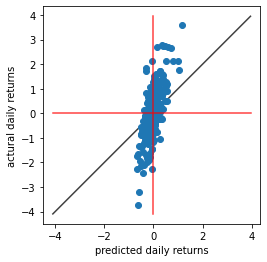

In [4603]:
show_prediction_scatter(prediction, actual)

In [4604]:
rf_result.sort_values(by='prediction', ascending=False).head(10)

,prediction,actual
9468.T,1.159543,3.583615
9766.T,1.021422,1.760569
9706.T,1.007869,2.123142
9697.T,0.801843,2.126099
7936.T,0.694598,2.637794
9201.T,0.610881,2.678144
6098.T,0.559616,1.208466
7276.T,0.553039,0.507608
4901.T,0.536605,0.924068
9831.T,0.528438,1.291996


## XGBOOST

In [4605]:
#with open('models/jp_xgb_v4.pickle', 'rb') as handle:
#    xgb = pickle.load(handle)

### Predict

In [4606]:
prediction = xgb.predict(predicting_std)

In [4607]:
predicted_max_ret = prediction.max()
predicted_max_i = prediction.argmax()
ticker = ticker_encoder.classes_[int(predicting.iloc[predicted_max_i]['ticker'])]

print(f'Date: {datetime.date.today()+ datetime.timedelta(days=1)}')
print(f'Ticker: {ticker}')
print(f'Predicted max daily return: {predicted_max_ret}')

Date: 2022-07-13
Ticker: 6920.T
Predicted max daily return: 1.4027562141418457


In [4608]:
data = {
    'prediction': list(prediction),
    'actual': [actual.iloc[i] for i in range(len(prediction))],
}

xgb_result = pd.DataFrame(data)
xgb_result.index = [ticker_encoder.classes_[int(predicting.iloc[i]['ticker'])] for i in xgb_result.index]

### Result

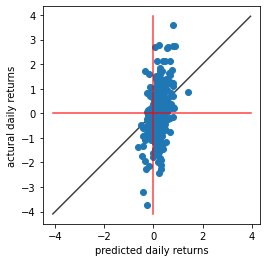

In [4609]:
show_prediction_scatter(prediction, actual)

In [4610]:
xgb_result.sort_values(by='prediction', ascending=False).head(10)

,prediction,actual
6920.T,1.402756,0.883285
4689.T,0.897444,2.743989
7272.T,0.826412,0.220348
4751.T,0.808759,0.259740
7269.T,0.805007,1.104207
7270.T,0.795642,0.694277
7202.T,0.791399,-0.137645
6723.T,0.780229,2.751629
4516.T,0.779676,1.231530
9468.T,0.778812,3.583615


## LightBGM

In [4611]:
#with open('models/jp_lgbm_v4.pickle', 'rb') as handle:
#    lbgm = pickle.load(handle)

### Predict

In [4612]:
prediction = lbgm.predict(predicting_std)

In [4613]:
predicted_max_ret = prediction.max()
predicted_max_i = prediction.argmax()
ticker = ticker_encoder.classes_[int(predicting.iloc[predicted_max_i]['ticker'])]

print(f'Date: {datetime.date.today()+ datetime.timedelta(days=1)}')
print(f'Ticker: {ticker}')
print(f'Predicted max daily return: {predicted_max_ret}')

Date: 2022-07-13
Ticker: 9983.T
Predicted max daily return: 1.2684369331563734


In [4614]:
data = {
    'prediction': list(prediction),
    'actual': [actual.iloc[i] for i in range(len(prediction))],
}

lgbm_result = pd.DataFrame(data)
lgbm_result.index = [ticker_encoder.classes_[int(predicting.iloc[i]['ticker'])] for i in lgbm_result.index]

### Result

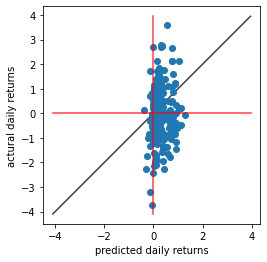

In [4615]:
show_prediction_scatter(prediction, actual)

In [4616]:
lgbm_result.sort_values(by='prediction', ascending=False).head(10)

,prediction,actual
9983.T,1.268437,-0.073158
8952.T,1.136474,-0.462242
2413.T,1.106733,0.209902
7951.T,1.040779,0.174518
9697.T,1.026508,2.126099
8951.T,0.945559,-0.586508
9041.T,0.928198,-0.455925
6586.T,0.912445,-1.435210
6701.T,0.911371,-0.375234
6465.T,0.908513,0.349651


# Merge Results

In [4617]:
merged_result = pd.concat(
    [
        rf_result.add_prefix('rf_'),
        xgb_result.add_prefix('xgb_'),
        lgbm_result.add_prefix('lgbm_')
    ], join='inner', axis=1)
merged_result.drop(['rf_actual'], axis=1, inplace=True)
merged_result.drop(['lgbm_actual'], axis=1, inplace=True)
merged_result.rename(columns={'xgb_actual': 'actual'}, inplace=True)

In [4618]:
merged_result

,rf_prediction,xgb_prediction,actual,lgbm_prediction
7203.T,-0.094548,0.460869,-0.676161,-0.000724
1306.T,0.047847,0.210334,-0.097513,0.073922
9432.T,-0.358139,0.092329,-0.530592,0.227197
6758.T,0.338320,0.225164,2.766513,0.301743
6861.T,-0.014322,0.184005,0.520263,0.412565
...,...,...,...,...
8369.T,-0.369503,0.326475,-2.095810,0.122846
4403.T,-0.234195,0.393868,-1.234570,0.153610
9508.T,-0.142920,-0.031778,-1.614763,0.036074
9513.T,-0.256032,-0.221509,-0.065232,-0.064978


## Stacking prediction

In [4619]:
#with open('models/xgb_stack_v4.pickle', 'rb') as handle:
#    stacking = pickle.load(handle)

### Stacking predict

In [4620]:
base_preds = merged_result.copy(deep=True)

In [4621]:
prediction = stacking.predict(base_preds.drop(['actual'], axis=1))

In [4622]:
data = {
    'prediction': list(prediction),
    'actual': [base_preds['actual'].iloc[i] for i in range(len(prediction))],
}

stacked_result = pd.DataFrame(data)
stacked_result.index = base_preds.index

### Stacking result

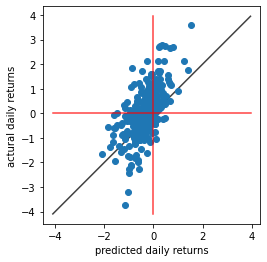

In [4623]:
show_prediction_scatter(prediction, base_preds["actual"])

In [4624]:
stacked_result.sort_values(by='prediction', ascending=False).head(10)

,prediction,actual
9468.T,1.544006,3.583615
9766.T,1.422225,1.760569
9706.T,1.250762,2.123142
4901.T,1.015377,0.924068
9201.T,0.805148,2.678144
9202.T,0.717542,1.167315
6098.T,0.693462,1.208466
7936.T,0.673015,2.637794
9602.T,0.672874,0.500498
9831.T,0.646584,1.291996


## merge by adding all prediction

In [4625]:
merged_result["prediction"] = (merged_result['rf_prediction'] + merged_result['xgb_prediction'] + merged_result['lgbm_prediction'])/3
merged_result.drop(columns=['rf_prediction', 'xgb_prediction', 'lgbm_prediction'], inplace=True)

In [4626]:
merged_result.sort_values(by='prediction', ascending=False).head(10)

,actual,prediction
9697.T,2.126099,0.837952
9468.T,3.583615,0.835431
9706.T,2.123142,0.745995
9766.T,1.760569,0.738665
6920.T,0.883285,0.733847
7936.T,2.637794,0.669778
2413.T,0.209902,0.642318
7269.T,1.104207,0.636913
4516.T,1.231530,0.631432
7951.T,0.174518,0.592680


In [4627]:
merged_result.sort_values(by='prediction', ascending=False).head(10)["actual"].sum()/10

1.5834661704393804

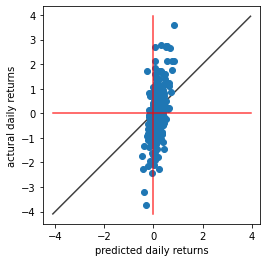

In [4628]:
show_prediction_scatter(merged_result['prediction'], merged_result['actual'])

# Compare

In [4629]:
buying_num = 3

xgb_ave = xgb_result.sort_values(by='prediction', ascending=False).head(buying_num)["actual"].sum()/buying_num
lgbm_ave = lgbm_result.sort_values(by='prediction', ascending=False).head(buying_num)["actual"].sum()/buying_num
rf_ave = rf_result.sort_values(by='prediction', ascending=False).head(buying_num)["actual"].sum()/buying_num
stack_ave = stacked_result.sort_values(by='prediction', ascending=False).head(buying_num)["actual"].sum()/buying_num
summing_ave = merged_result.sort_values(by='prediction', ascending=False).head(buying_num)["actual"].sum()/buying_num

data = {
    "daily return": [xgb_ave, lgbm_ave, rf_ave, stack_ave, summing_ave]
}

pd.DataFrame(data, index=['xgb', 'lgbm', 'rf', 'stack', 'summing'])

,daily return
xgb,1.282541
lgbm,-0.108499
rf,2.489109
stack,2.489109
summing,2.610952
